In [ ]:
import torch
import torch.nn as nn

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("device"))
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import json

In [ ]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

--2023-04-26 23:04:43--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2023-04-26 23:04:43--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  22.8MB/s    in 0.5s    

2023-04-26 23:04:44 (22.8 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



(106, 100, 100, 3) (106, 4, 4) 138.88887889922103
100 100


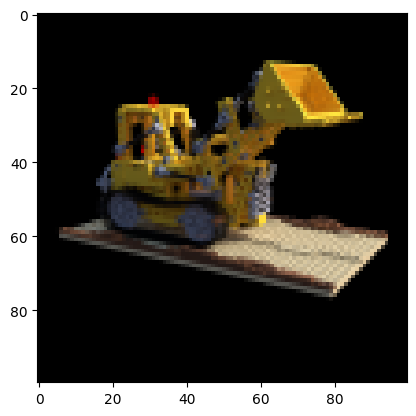

In [ ]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = torch.from_numpy(images[10]).to(device),torch.from_numpy(poses[10]).to(device)
images = torch.from_numpy(images[:105,...,:3]).to(device)
poses = torch.from_numpy(poses[:105]).to(device)
print(H,W)
plt.imshow(testimg.detach().cpu().numpy())
plt.show()

In [ ]:
class Nerf(nn.Module):
    def __init__(self):
        super(Nerf, self).__init__()
        self.lay1 = nn.Linear(39,256)
        self.lay2 = nn.Linear(256,256)
        self.lay3 = nn.Linear(256,4)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        x = self.lay1(x)
        x = self.relu(x)
        x = self.lay2(x)
        x = self.relu(x)
        x = self.lay3(x)
        return x


In [ ]:
model = Nerf().to(device)
#model.load_state_dict(torch.load('/content/drive/MyDrive/models/lego.pth', map_location=torch.device(device)))
optimizer = torch.optim.AdamW(model.parameters(),lr = 5e-4)
loss_fn = nn.MSELoss()
N_samples = 64
N_iters = 100
psnrs = []
iternums = []
i_plot = 25

In [ ]:
def get_rays(H,W,focal,pose):
    i,j = torch.meshgrid(torch.arange(W,dtype=torch.float32),torch.arange(H,dtype=torch.float32),indexing='xy')
    dirs = torch.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -torch.ones_like(i)], -1)
    dirs = dirs.to(device)
    rays_d = torch.sum(dirs[...,None, :]*pose[:3,:3],dim=-1)
    rays_o = torch.broadcast_to(torch.tensor(pose[:3,-1],dtype=torch.float32),rays_d.size())
    return rays_o, rays_d

In [ ]:
def posenc(x):
    rets = [x]
    L_embed = 6
    for i in range(L_embed):
        for fn in [torch.sin, torch.cos]:
            rets.append(fn(2.**i * x))
    return torch.concat(rets, -1)
embed_fn = posenc

In [ ]:
def cumprod_exclusive(t):
  cumprod = torch.cumprod(t, -1)
  cumprod = torch.roll(cumprod, 1, -1)
  cumprod[..., 0] = 1.
  return cumprod

In [ ]:
def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):
    def batchify(fn, chunk=1024*32):
        return lambda inputs : torch.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.size()[0], chunk)], 0)
    
    z_vals = torch.linspace(near,far,N_samples).to(device)
    if rand:
        #z_vals += torch.rand(list(rays_o.shape[:-1]) + [N_samples])* (far-near)/N_samples
        noise_shape = list(rays_o.shape[:-1]) + [N_samples]
        z_vals = z_vals + torch.rand(noise_shape).to(rays_o) * (far - near) / N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    pts_flat = torch.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(model)(pts_flat)
    raw = torch.reshape(raw, list(pts.size()[:-1]) + [4])
    
    sigma_a = nn.ReLU()(raw[...,3])
    rgb = torch.sigmoid(raw[...,:3])
    
    dists = torch.concat([z_vals[..., 1:] - z_vals[..., :-1], torch.broadcast_to(torch.tensor([1e10]).to(device), z_vals[...,:1].shape)], -1) 
    alpha = 1.-torch.exp(-sigma_a * dists)
    weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)
    
    rgb_map = torch.sum(weights[...,None] * rgb, -2)
    depth_map = torch.sum(weights * z_vals, -1) 
    acc_map = torch.sum(weights, -1)
    
    return rgb_map, depth_map, acc_map

  0%|          | 0/1400 [00:00<?, ?it/s]

<ipython-input-13-0cd041a31ec7>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rays_o = torch.broadcast_to(torch.tensor(pose[:3,-1],dtype=torch.float32),rays_d.size())


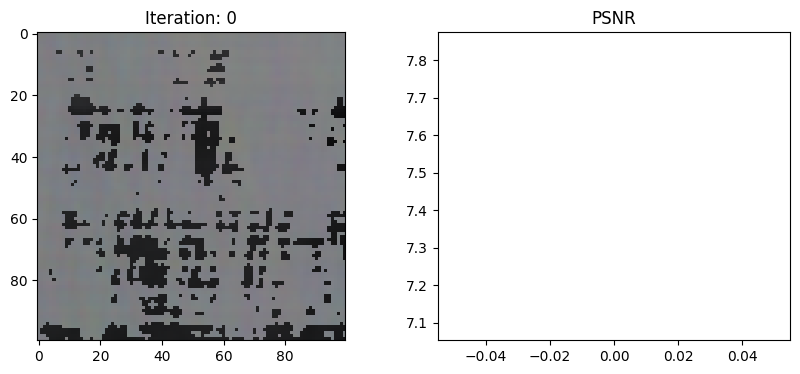

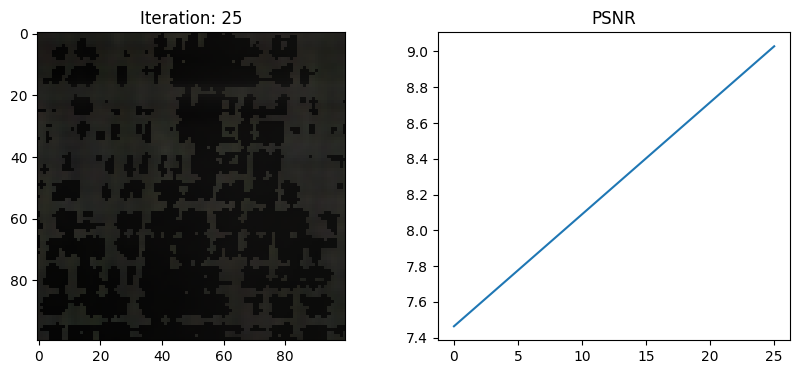

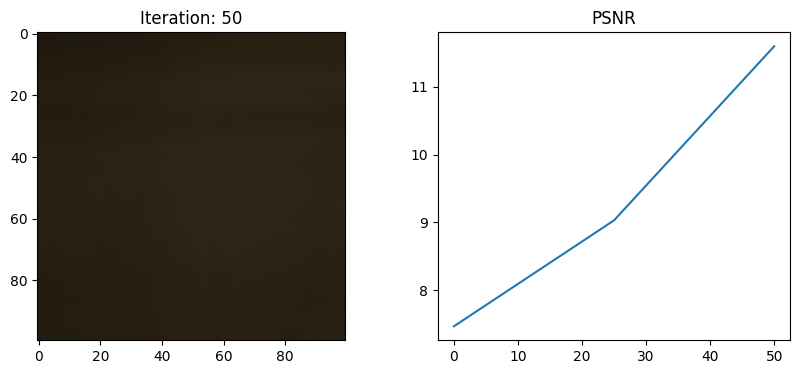

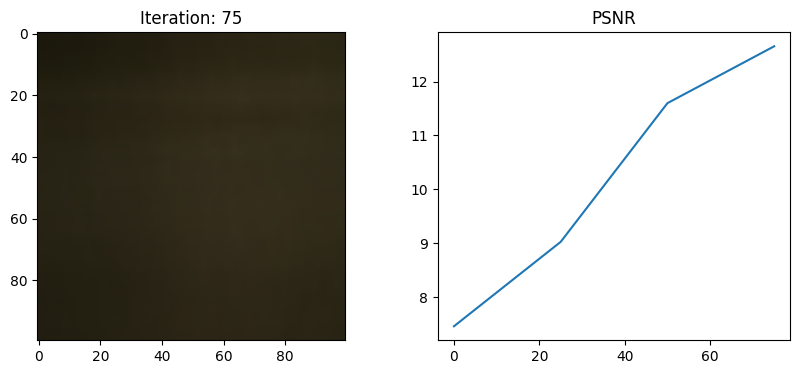

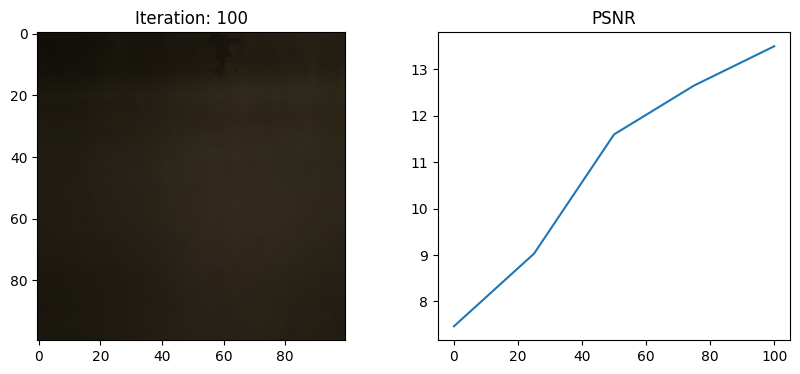

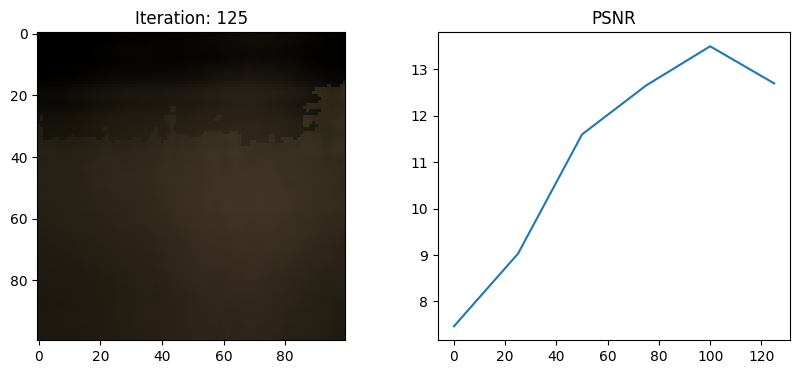

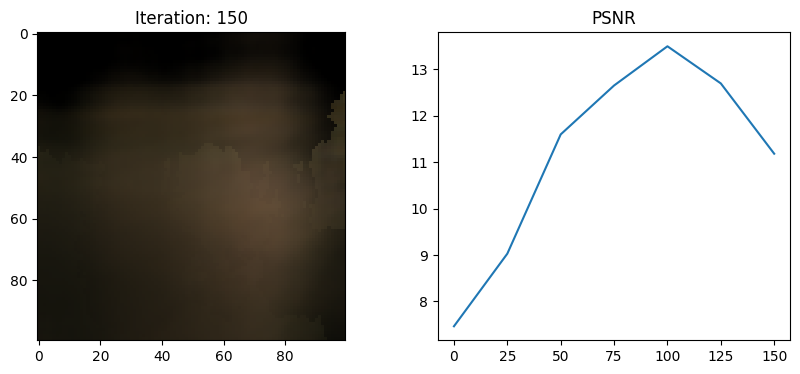

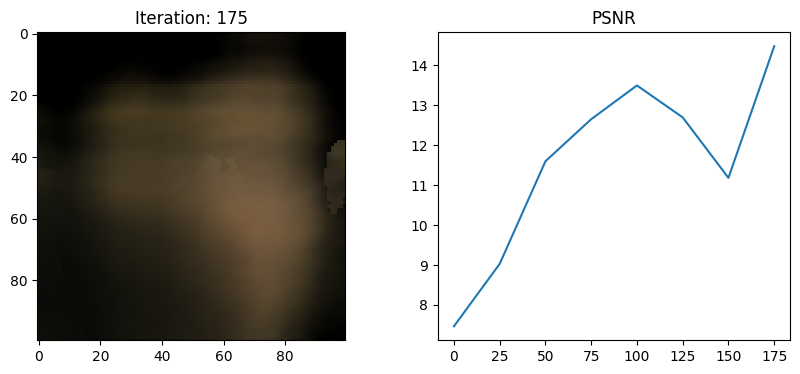

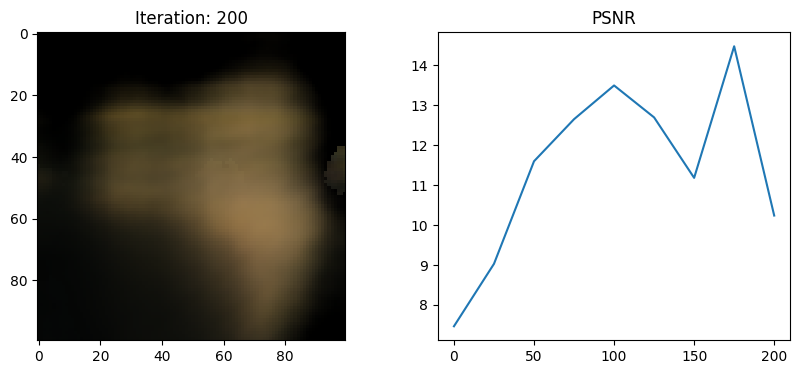

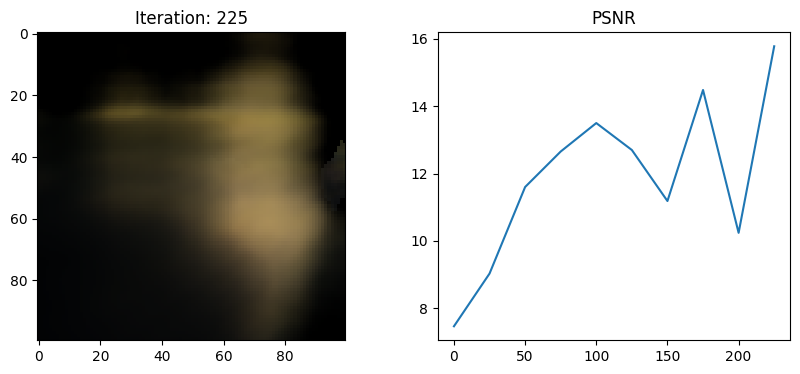

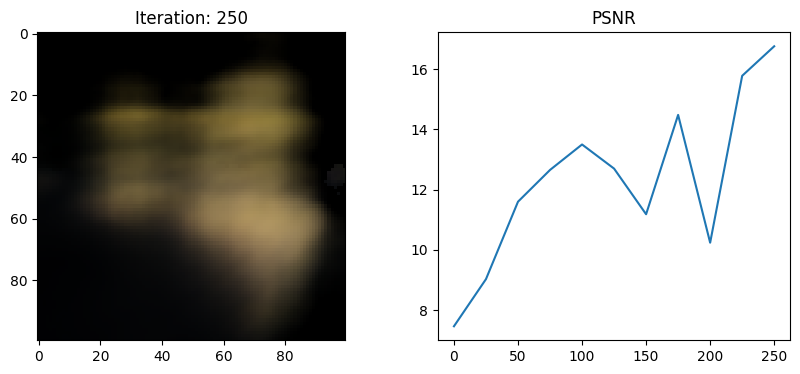

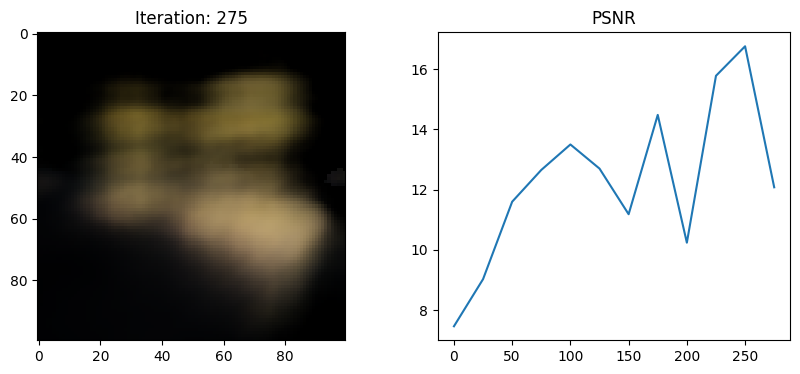

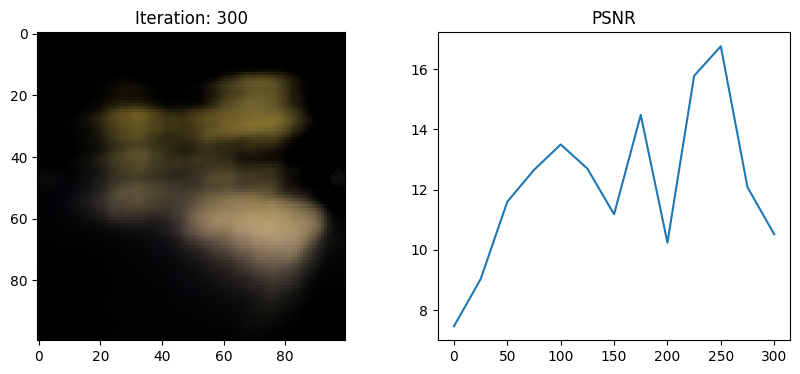

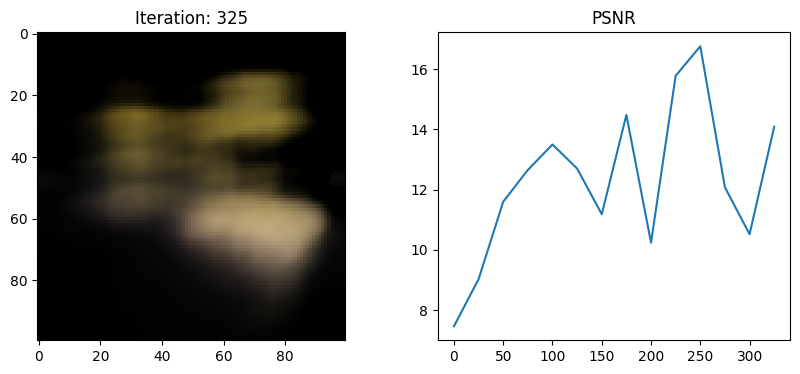

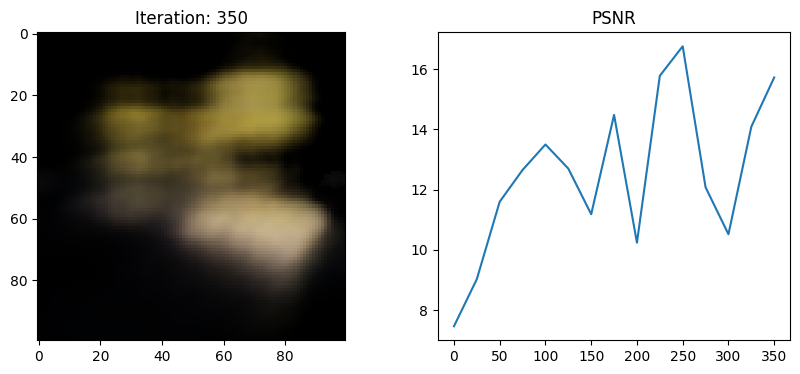

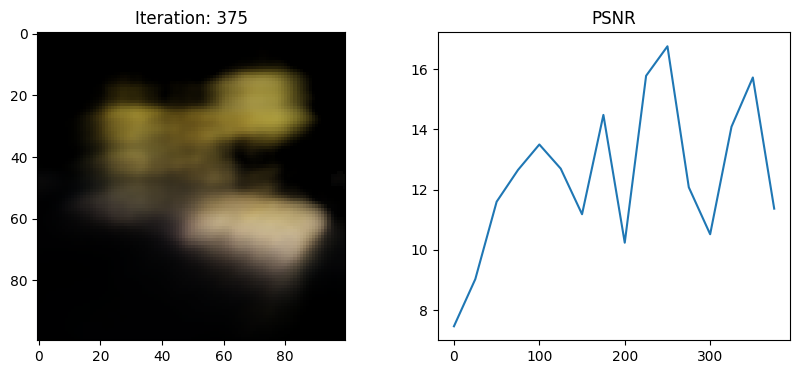

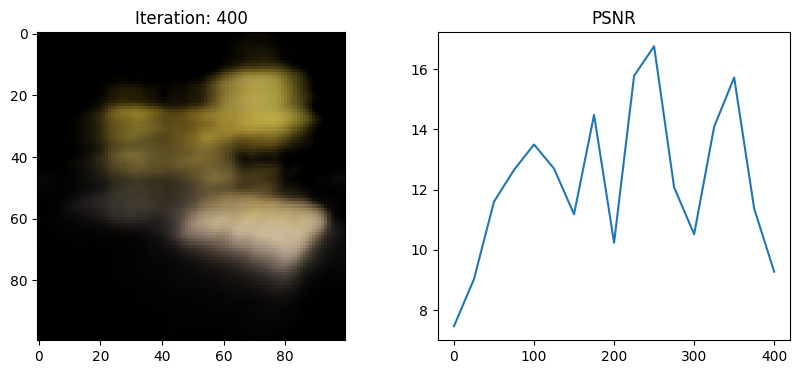

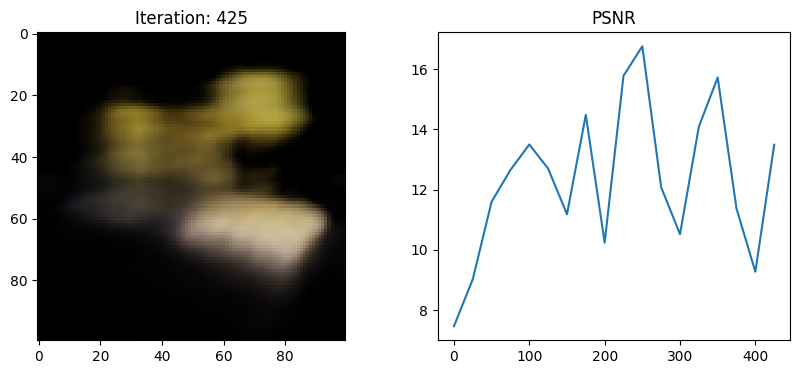

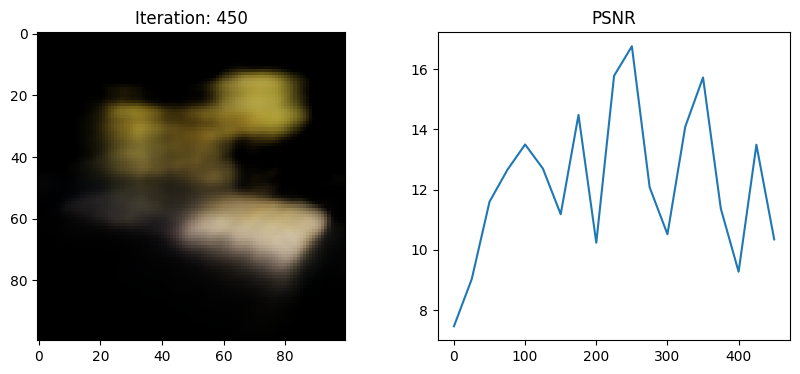

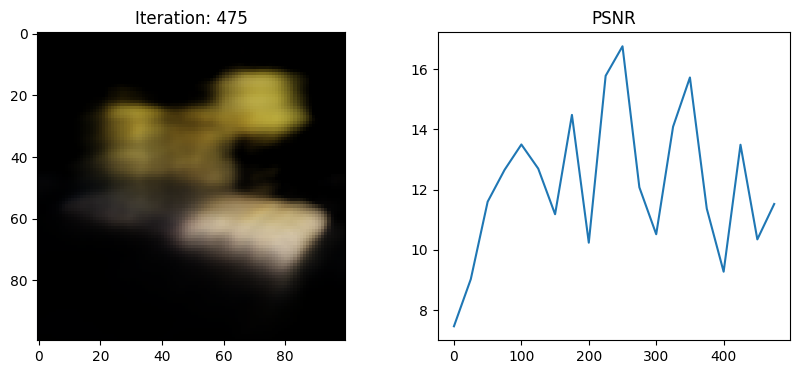

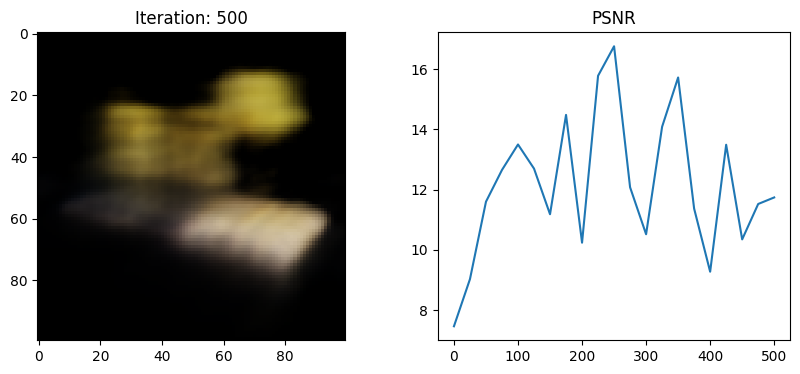

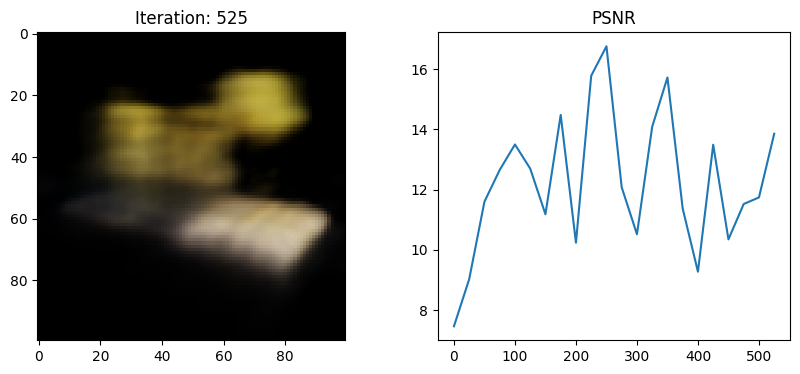

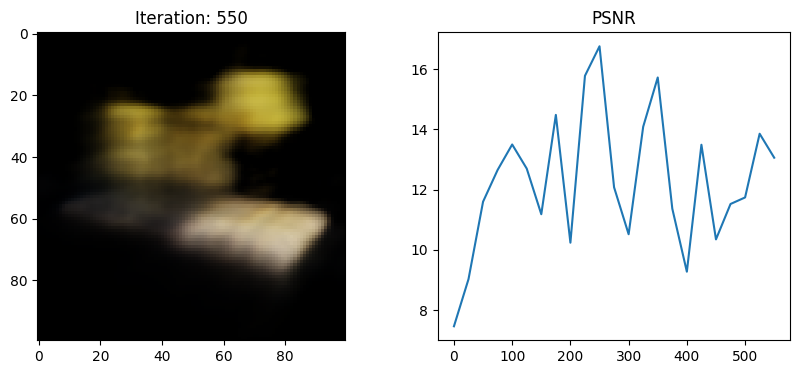

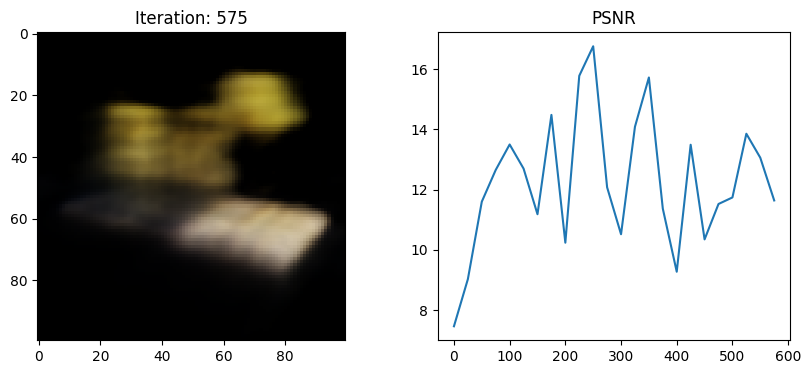

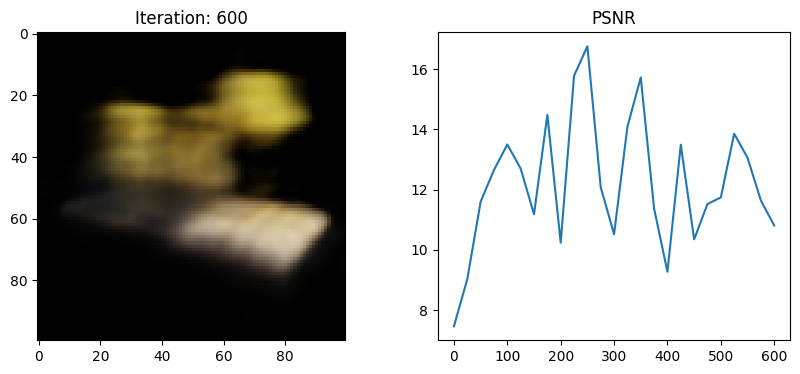

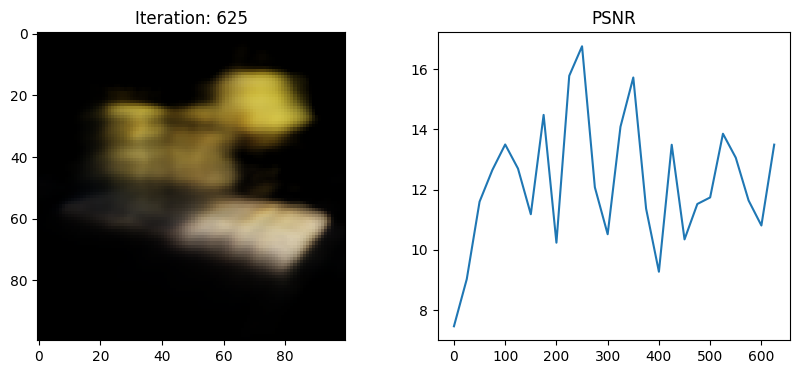

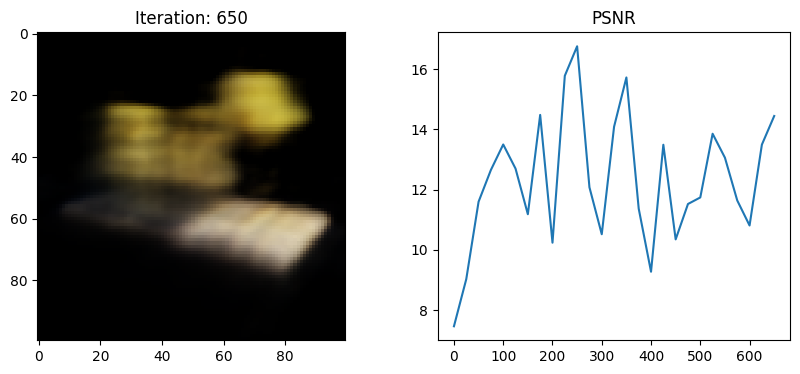

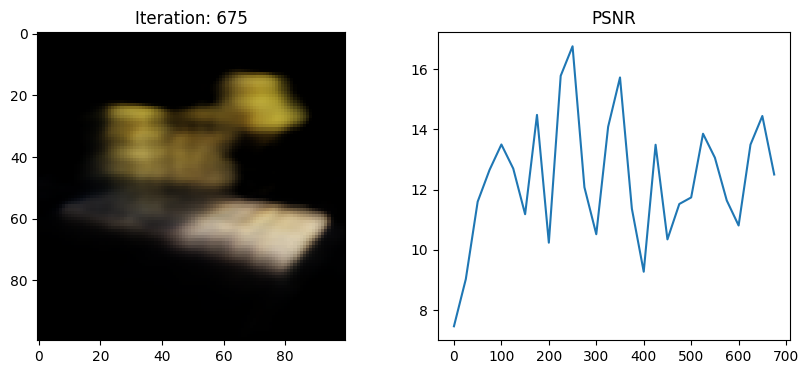

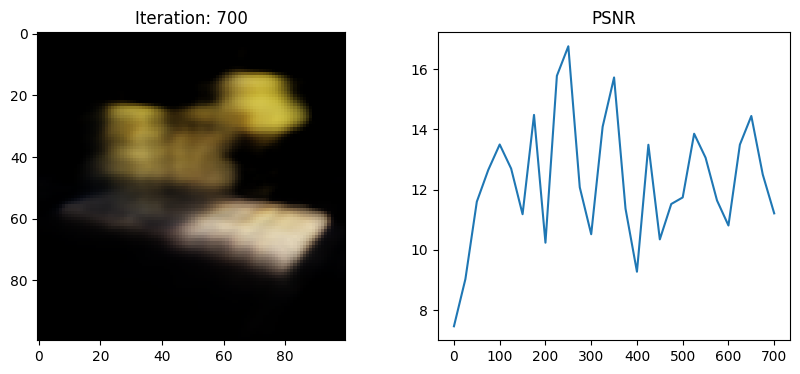

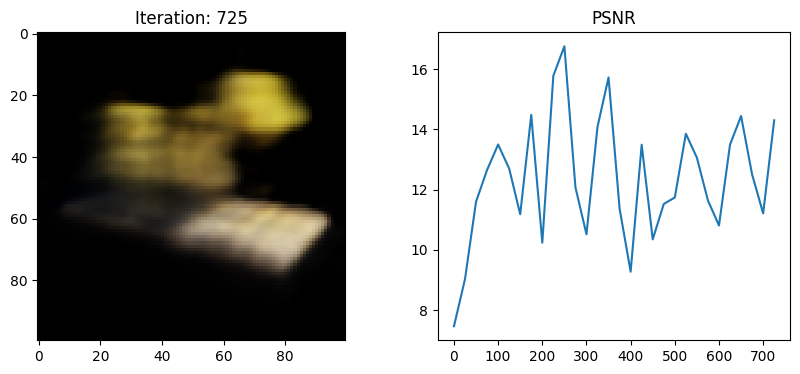

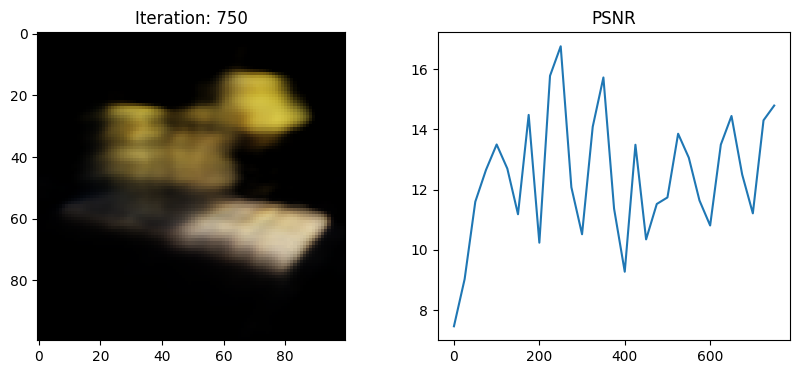

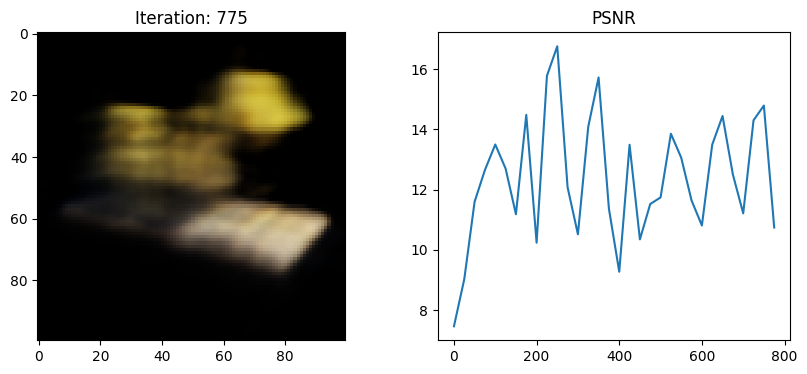

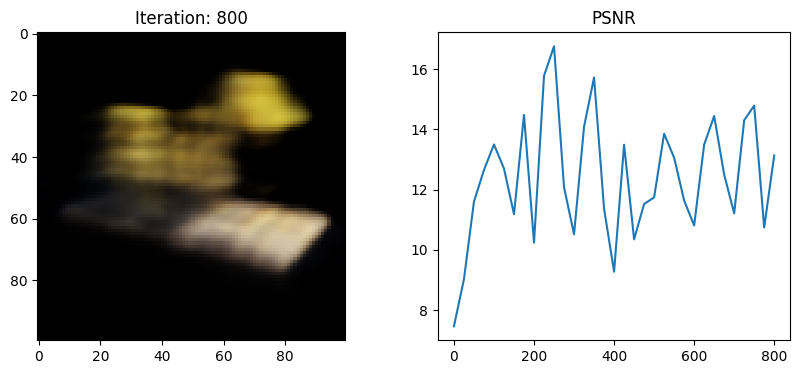

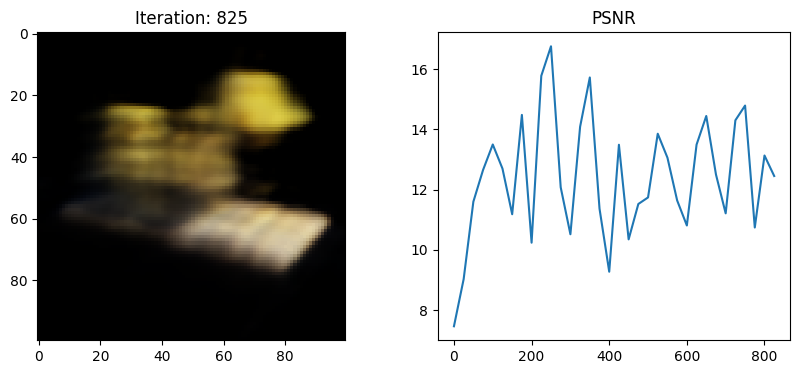

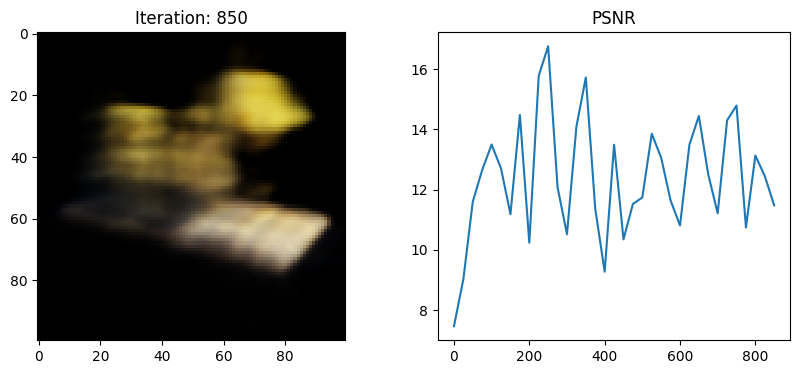

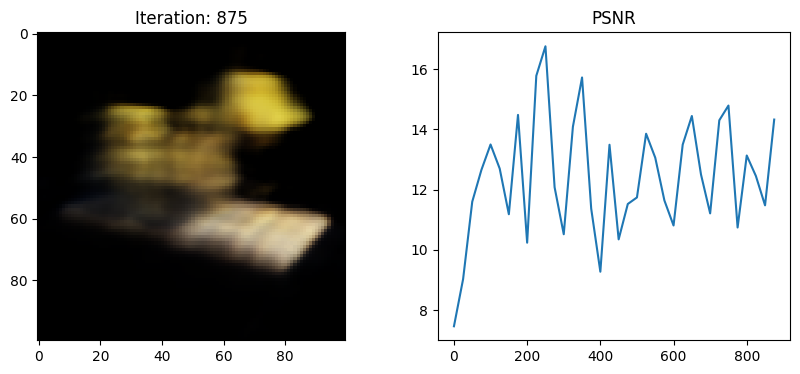

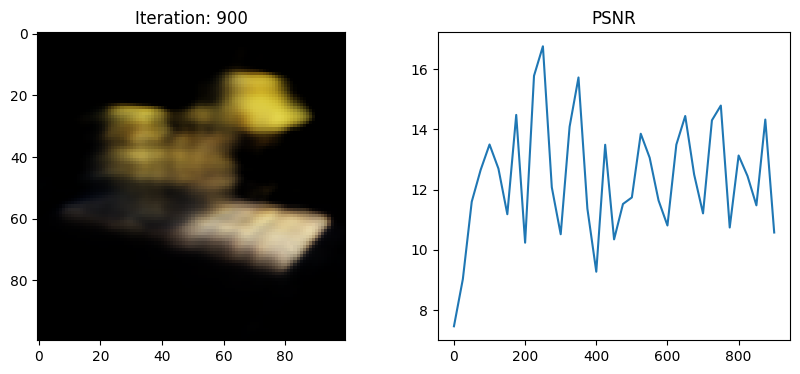

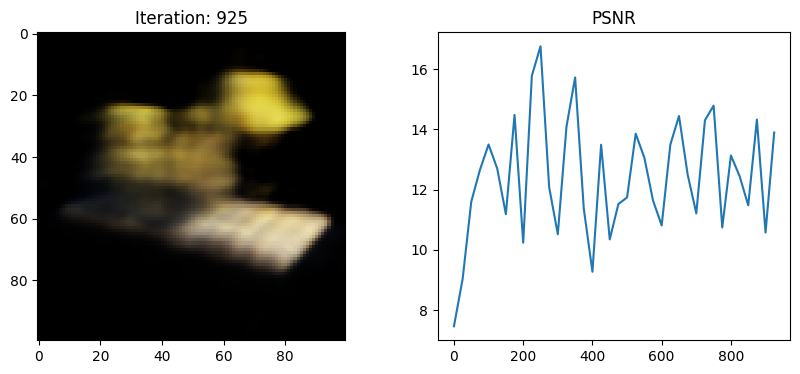

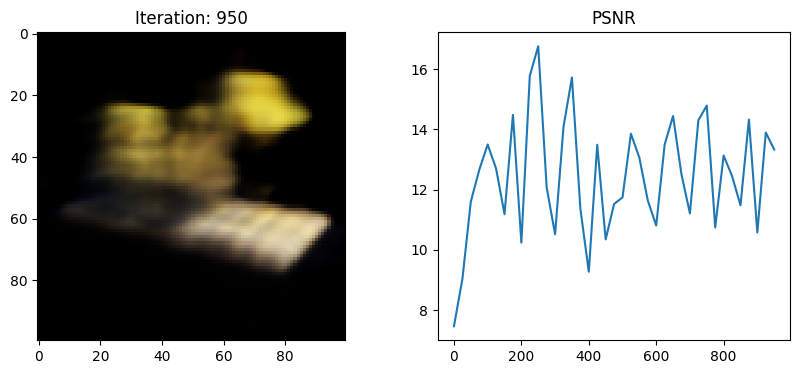

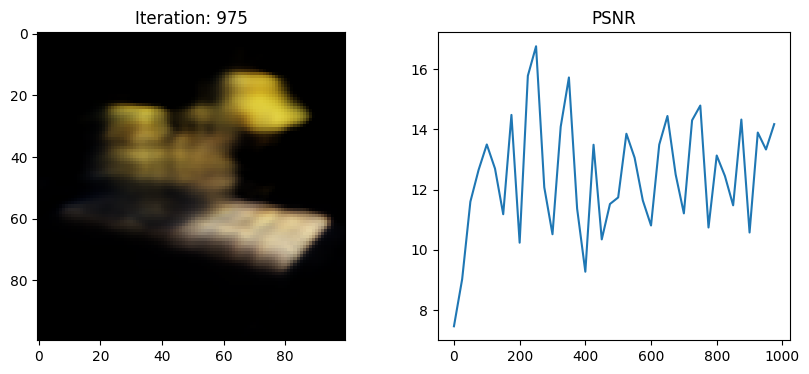

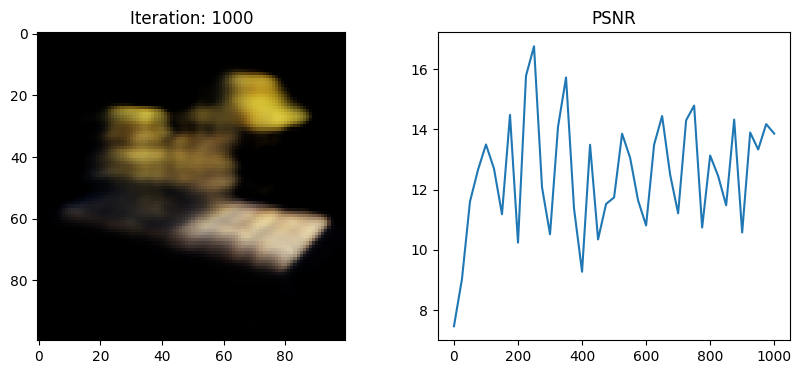

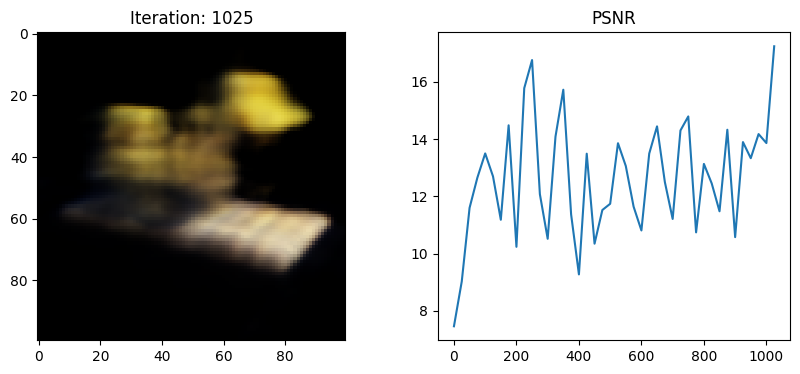

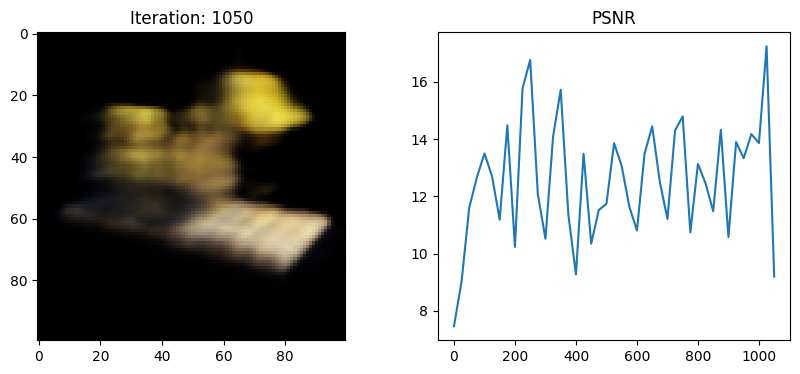

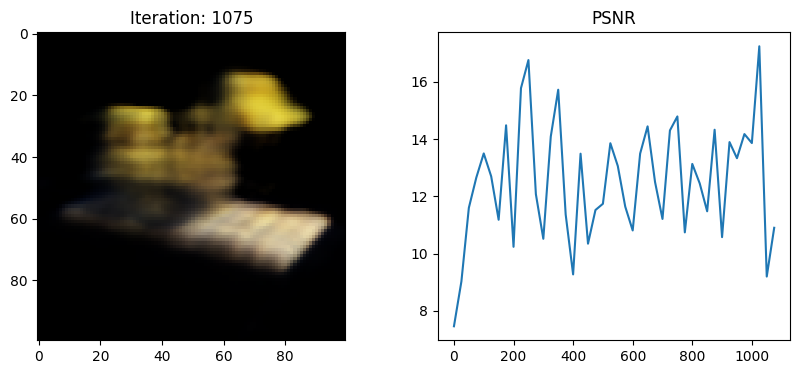

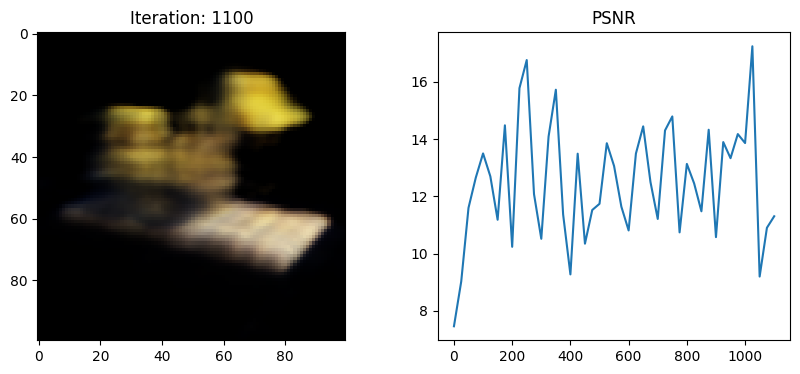

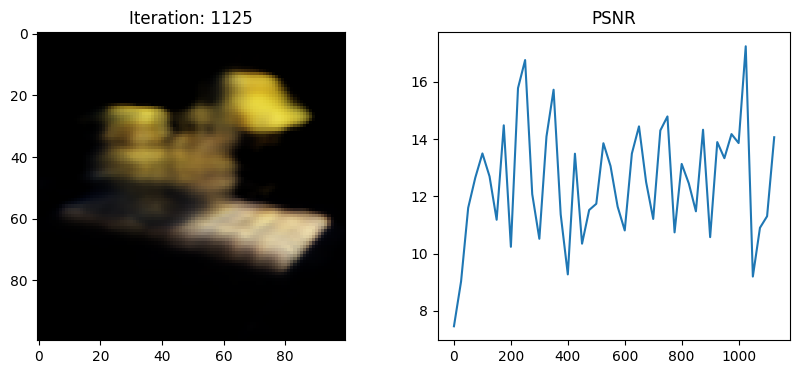

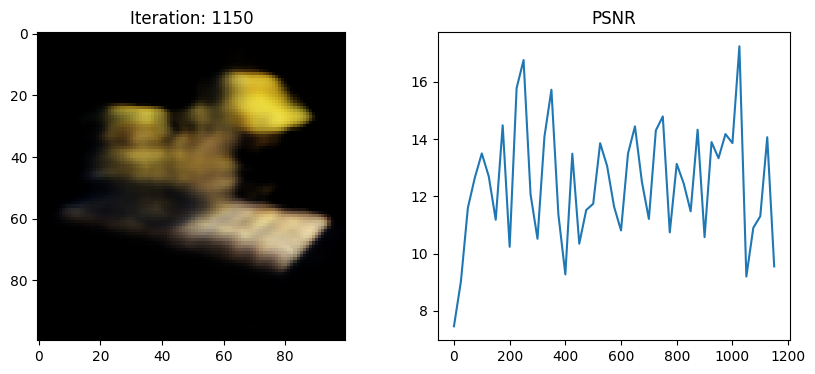

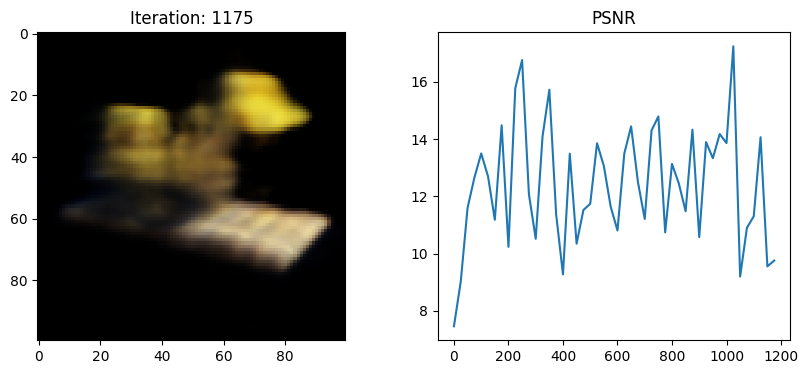

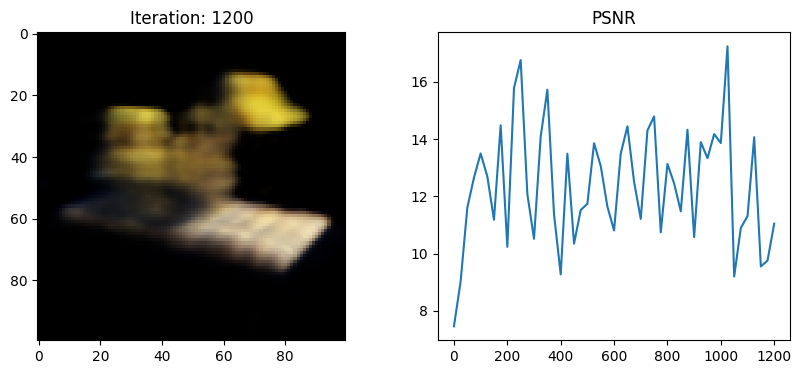

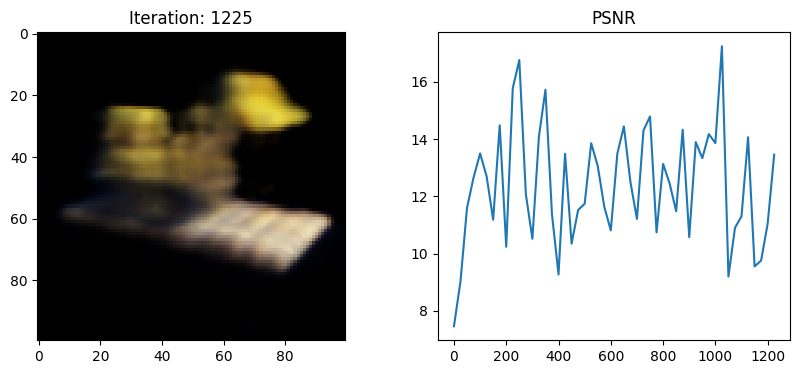

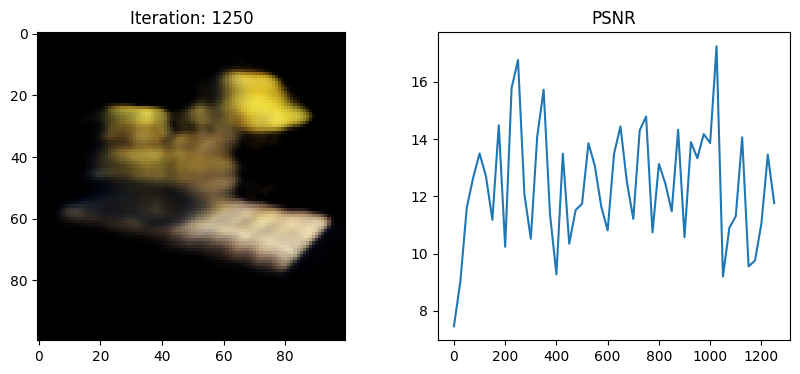

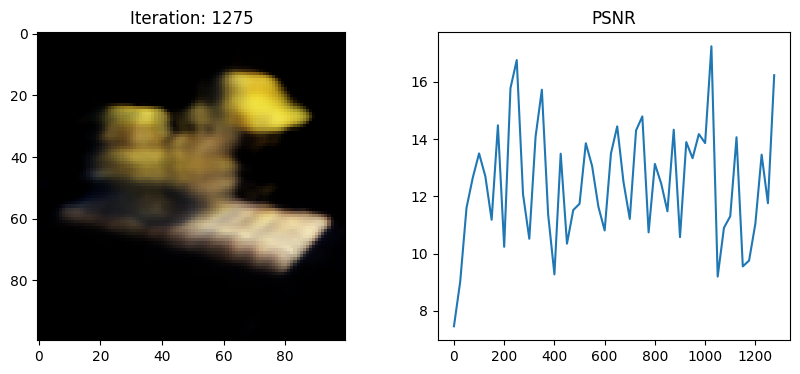

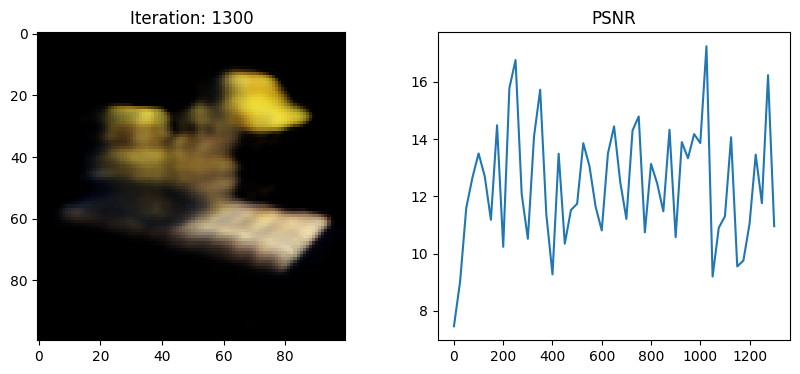

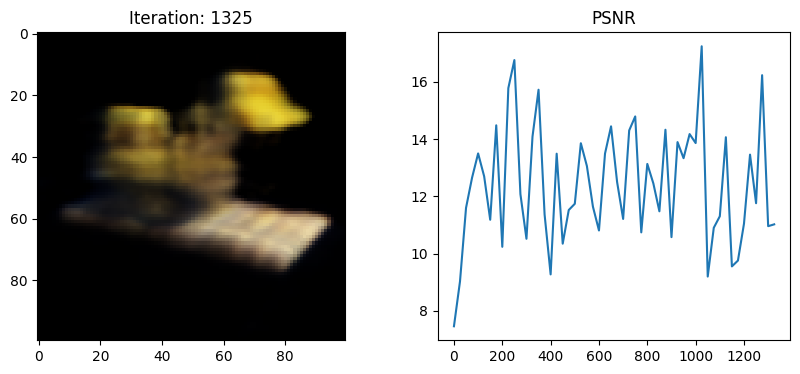

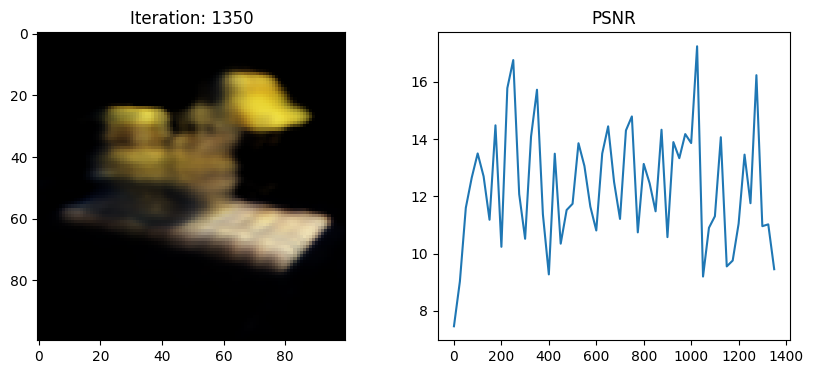

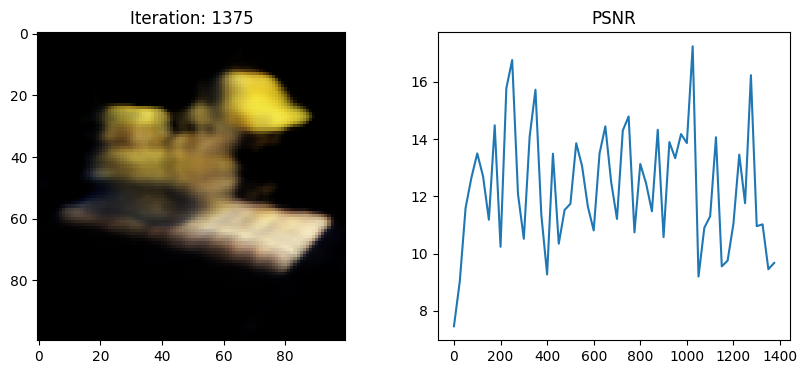

Done


214.4108591079712

In [ ]:
import time
st = time.time()
model.train()
for i in tqdm(range(1400)):
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    optimizer.zero_grad()
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
    loss = loss_fn(rgb,target)
    loss.backward()
    optimizer.step()
    if i%i_plot==0:
        t = time.time()
        model.eval()
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = loss_fn(rgb,target)
        psnr = -10. * torch.log(loss) / torch.log(torch.tensor(10.))
        psnrs.append(psnr.item())
        iternums.append(i)
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb.detach().cpu().numpy())
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')
et = time.time()
et-st

<ipython-input-13-0cd041a31ec7>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rays_o = torch.broadcast_to(torch.tensor(pose[:3,-1],dtype=torch.float32),rays_d.size())


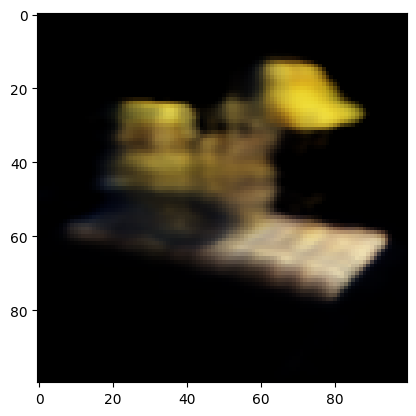

In [ ]:
rays_o, rays_d = get_rays(H, W, focal, testpose)
rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
loss = loss_fn(rgb,target)
plt.imshow(rgb.detach().cpu().numpy())
plt.show()

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : torch.tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=torch.float32)

rot_phi = lambda phi : torch.tensor([
    [1,0,0,0],
    [0,torch.cos(torch.tensor(phi)),-torch.sin(torch.tensor(phi)),0],
    [0,torch.sin(torch.tensor(phi)), torch.cos(torch.tensor(phi)),0],
    [0,0,0,1],
], dtype=torch.float32)

rot_theta = lambda th : torch.tensor([
    [torch.cos(torch.tensor(th)),0,-torch.sin(torch.tensor(th)),0],
    [0,1,0,0],
    [torch.sin(torch.tensor(th)),0, torch.cos(torch.tensor(th)),0],
    [0,0,0,1],
    
], dtype=torch.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = torch.tensor(np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]),dtype=torch.float32) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4].to(device))
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb.cpu().detach().numpy(),0,1)  
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

In [ ]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4].to(device))
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb.cpu().detach().numpy(),0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

  0%|          | 0/120 [00:00<?, ?it/s]

<ipython-input-13-0cd041a31ec7>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rays_o = torch.broadcast_to(torch.tensor(pose[:3,-1],dtype=torch.float32),rays_d.size())


In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
torch.save(model.state_dict(),"/content/drive/MyDrive/models/lego.pth")